In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
# y_test.shape, y_val.shape, y_train.shape

M, D, C = X_train.shape[0], X_train.shape[1], y_train.max() + 1
# M, D, C

X_train, X_val, X_test = l.prepro(X_train, X_val, X_test)
# X_train.shape, X_val.shape, X_test.shape
# if net_type == 'cnn':
img_shape = (1, 28, 28)
img_shape[:]
# *img_shape
# X_train = X_train.reshape(-1, img_shape[:])
X_train = X_train.reshape(-1, *img_shape)
# X_train = X_train.reshape(-1, img_shape[0], img_shape[1], img_shape[2])
X_val = X_val.reshape(-1, *img_shape)
X_test = X_test.reshape(-1, *img_shape)
X_train.shape, X_val.shape, X_test.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((55000, 1, 28, 28), (5000, 1, 28, 28), (10000, 1, 28, 28))

In [2]:
# Model
import impl.layer as l
from sklearn.utils import shuffle as skshuffle

class CNN:

    def __init__(self, D, C, H, L, p_dropout):
        self.mode = 'classification'
        self.L = L # number of layers or depth
        self.p_dropout = p_dropout
        self.losses = {'train':[], 'smooth train':[]}
        
        # Model parameters: weights and biases
        # Input layer of Conv
        self.model = []
        self.model.append(dict(
            W1=np.random.randn(H, 1, 3, 3) / np.sqrt(H / 2.),
            b1=np.zeros((H, 1)),
        ))
        
        # Hidden layers of Conv-bn-relu-dropout
        m = []
        for _ in range(self.L):
            m.append(dict(
                    W2=np.random.randn(H, H, 3, 3) / np.sqrt(H / 2.),
                    b2=np.zeros((H, 1)),
            ))
        self.model.append(m) # self.model[0][]
        
        # Output layer of FC to output
        self.model.append(dict(
            W3=np.random.randn(H*D, C) / np.sqrt(H*D / 2.),
            b3=np.zeros((1, C))
        ))

    def selu_forward(self, X):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
        cache = X
        return out, cache

    def selu_backward(self, dout, cache):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        X = cache
        dX_pos = dout.copy()
        dX_pos[X<0] = 0
        dX_neg = dout.copy()
        dX_neg[X>0] = 0
        dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
        return dX

    # p_dropout = keep_prob in this case! 
    # Is this true in other cases as well?
    def alpha_dropout_fwd(self, h, q):
        '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        alpha_p = -scale * alpha
        mask = np.random.binomial(1, q, size=h.shape)
        dropped = (mask * h) + ((1 - mask) * alpha_p)
        a = 1. / np.sqrt(q + (alpha_p ** 2 * q  * (1 - q)))
        b = -a * (1 - q) * alpha_p
        out = (a * dropped) + b
        cache = (a, mask)
        return out, cache

    def alpha_dropout_bwd(self, dout, cache):
        a, mask = cache
        d_dropped = dout * a
        dh = d_dropped * mask
        return dh

    def forward(self, X, train):
        # 1st layer - Input layer: X
        X, X_conv_cache = l.conv_forward(X=X, W=self.model[0]['W1'], b=self.model[0]['b1'])
        X_cache = X_conv_cache

        # 2nd layers - Hidden layers: h
        h_cache = []
        for layer in range(self.L):
            h, h_conv_cache = l.conv_forward(X=X, W=self.model[1][layer]['W2'], b=self.model[1][layer]['b2'])
            h, h_nl_cache = self.selu_forward(X=h)
            h += X # residual connection
            if train: 
                # h_do_cache = None # ERROR: referenced before assigned?
                h, h_do_cache = self.alpha_dropout_fwd(h=h, q=self.p_dropout)
                cache = (h_conv_cache, h_nl_cache, h_do_cache)
            else:
                cache = (h_conv_cache, h_nl_cache)
            h_cache.append(cache)
            
        # 3rd layer - Output layer: y
        y = h.reshape([X.shape[0], -1]) # flattening
        y, y_fc_cache = l.fc_forward(X=y, W=self.model[2]['W3'], b=self.model[2]['b3'])
        y_cache = X, y_fc_cache

        cache = (X_cache, h_cache, y_cache)
        
        return y, cache

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y

    def loss_function(self, y, y_train):
        loss = self.cross_entropy(y, y_train)
        dy = self.dcross_entropy(y, y_train)
        return loss, dy
    
    def backward(self, dy, cache, train):
        X_cache, h_cache, y_cache = cache

        # 3rd layer: Ouput layer y
        X, y_fc_cache = y_cache
        dy, dw3, db3 = l.fc_backward(dout=dy, cache=y_fc_cache)
        dy = dy.reshape([-1, *X.shape[1:4]])
        
        # 2nd layers: Hidden layers h
        g = []
        for layer in reversed(range(self.L)):
            if train:
                h_conv_cache, h_nl_cache, h_do_cache = h_cache[layer]
                dy = self.alpha_dropout_bwd(dout=dy, cache=h_do_cache)
            else:
                h_conv_cache, h_nl_cache = h_cache[layer]
            dh = self.selu_backward(dout=dy, cache=h_nl_cache)
            dh, dw2, db2 = l.conv_backward(dout=dh, cache=h_conv_cache)
            dh += dy
            g.append(dict(
                    W2=dw2,
                    b2=db2
                    ))
            
        # 1st layer: Input layer X
        X_conv_cache = X_cache
        dX, dw1, db1 = l.conv_backward(dout=dh, cache=X_conv_cache)

        # grad for GD
        grad = []
        
        # Input layer to conv layer
        grad.append(dict(
            W1=dw1, 
            b1=db1
        ))
        
        # Hidden layers of conv-bn-nl/relu-dropout/do
        grad.append(g)
        
        # Output later to FC layer
        grad.append(dict(
            W3=dw3, 
            b3=db3
        ))
        
        return dX, grad
    
    def test(self, X):
        y_logit, cache = self.forward(X, train=False)
        y_prob = l.softmax(y_logit)
        if self.mode == 'classification':
            return np.argmax(y_prob, axis=1)
        else: # self.mode == 'regression'
            return np.round(y_logit)
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam(self, X_train, y_train, val_set, alpha, mb_size, n_iter, print_after):
        if val_set:
            X_val, y_val = val_set

        M, R = [], []
        M.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        M_, R_ = [], []
        for layer in range(self.L):
            M_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
            R_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        M.append(M_)
        R.append(R_)

        M.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[2].items()})

        beta1 = .99
        beta2 = .999
        eps = 1e-8 # constant
        smooth_train = 1.0

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            #         """
            #         Single training step over minibatch: forward, loss, backprop
            #         """
            # Shuffle for each epochs/ stochasticity/ randomly choosing
            #             for idx in range(len(minibatches)):
            #             for _ in range(10):
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            y, cache = self.forward(X_mini, train=True)
            loss, dy = self.loss_function(y, y_mini)
            _, grad = self.backward(dy, cache, train=True)
            self.losses['train'].append(loss)
            smooth_train = (0.999 * smooth_train) + (0.001 * loss)
            self.losses['smooth train'].append(smooth_train)

            for key in grad[0]:
                M[0][key] = l.exp_running_avg(M[0][key], grad[0][key], beta1)
                R[0][key] = l.exp_running_avg(R[0][key], grad[0][key]**2, beta2)

                m_k_hat = M[0][key] / (1. - (beta1**(iter)))
                r_k_hat = R[0][key] / (1. - (beta2**(iter)))

                self.model[0][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

            for layer in range(self.L):
                for key in grad[1][layer]:
                    M[1][layer][key] = l.exp_running_avg(M[1][layer][key], grad[1][layer][key], beta1)
                    R[1][layer][key] = l.exp_running_avg(R[1][layer][key], grad[1][layer][key]**2, beta2)

                    m_k_hat = M[1][layer][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[1][layer][key] / (1. - (beta2**(iter)))

                    self.model[1][layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

            for key in grad[2]:
                M[2][key] = l.exp_running_avg(M[2][key], grad[2][key], beta1)
                R[2][key] = l.exp_running_avg(R[2][key], grad[2][key]**2, beta2)

                m_k_hat = M[2][key] / (1. - (beta1**(iter)))
                r_k_hat = R[2][key] / (1. - (beta2**(iter)))

                self.model[2][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

            # Epochs
            if iter % print_after == 0:
                if val_set:
                    val_acc = l.accuracy(y_val, self.test(X_val))
                    print('Iter-{} training loss: {:.4f} validation accuracy: {:4f}'.format(iter, loss, val_acc))

Iter-10 training loss: 2.2544 validation accuracy: 0.363200
Iter-20 training loss: 1.5534 validation accuracy: 0.590200
Iter-30 training loss: 0.9062 validation accuracy: 0.673600
Iter-40 training loss: 0.6448 validation accuracy: 0.762200
Iter-50 training loss: 0.7740 validation accuracy: 0.782600
Iter-60 training loss: 0.4196 validation accuracy: 0.813200
Iter-70 training loss: 0.6650 validation accuracy: 0.833800
Iter-80 training loss: 0.2239 validation accuracy: 0.839400
Iter-90 training loss: 0.7938 validation accuracy: 0.843400
Iter-100 training loss: 0.6154 validation accuracy: 0.857600
Iter-110 training loss: 0.4978 validation accuracy: 0.869200
Iter-120 training loss: 0.5324 validation accuracy: 0.868800
Iter-130 training loss: 0.6212 validation accuracy: 0.867400
Iter-140 training loss: 0.6551 validation accuracy: 0.873200
Iter-150 training loss: 0.3482 validation accuracy: 0.881400
Iter-160 training loss: 0.8693 validation accuracy: 0.881000
Iter-170 training loss: 0.3667 va

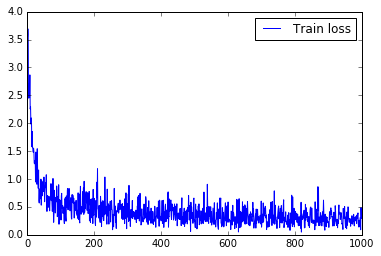

In [3]:
# Hyper-parameters
n_iter = 1000 # number of epochs
alpha = 1e-4 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
num_layers = 10 # depth 
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 10
p_dropout = 0.95 #  keep_prob = 1.0 - p_dropout, q = 1-p, q=0.95, o=0.05

# build the model/NN and learn it: running session.
nn = CNN(C=C, D=D, H=num_hidden_units, p_dropout=p_dropout, L=num_layers)

nn.adam(X_train=X_train, y_train=y_train, val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

y_pred = nn.test(X_test)
accs = np.mean(y_pred == y_test)
print('Test Mean accuracy: {:.4f}, std: {:.4f}'.format(accs.mean(), accs.std()))

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
# plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()